In [1]:
import sys
import numpy as np
import pandas as pd

from Dissects.io import (load_NDskl, 
                         load_image,
                         load_skeleton,
                         save_skeleton,
                         save_fits
                        )
from Dissects.image import (z_project,
                            thinning,
                            dilation)
from Dissects.geometry import Skeleton
from Dissects.segmentation.seg_2D import (segmentation, 
                                          junction_around_cell,
                                         vertices,
                                         junctions,
                                         generate_mesh)
from Dissects.analysis.analysis import (general_analysis,
                              cellstats
                              )

%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load image
image, metadata = load_image("/home/admin-suz/Documents/Code/Dissects/Dissects/stores/2d_images.tif")


In [3]:
pixel_ratio = metadata['pixel_ratio']
metadata

{'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}

In [4]:
# metadata={'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}

In [5]:
# #load ndskl file 
# cp, fil, point, specs = load_NDskl("/home/admin-suz/Documents/Code/Dissects/Dissects/stores/2d_images.NDskl.a.NDskl")
# #create skeleton object
# skel = Skeleton(cp, fil, point, specs)


In [6]:
# Load skeleton
data = load_skeleton('2d_skeleton.hf5')
skel = Skeleton(data['critical_point'], data['filament'], data['point'])

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:25: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  we take the integer part of xyz values. ")


In [7]:
#Clean skeleton
skel.remove_lonely_cp()
skel.remove_free_filament()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:61: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  "specs dictionnary is not updated, ncrit value is not updated.")


In [8]:
specs = {'ndims': 2,
 'bbox': np.array([0., 0.]),
 'bbox_delta': np.array([576., 337.]),
 'ncrit': 3525,
 'nfil': 3522}

<IPython.core.display.Javascript object>


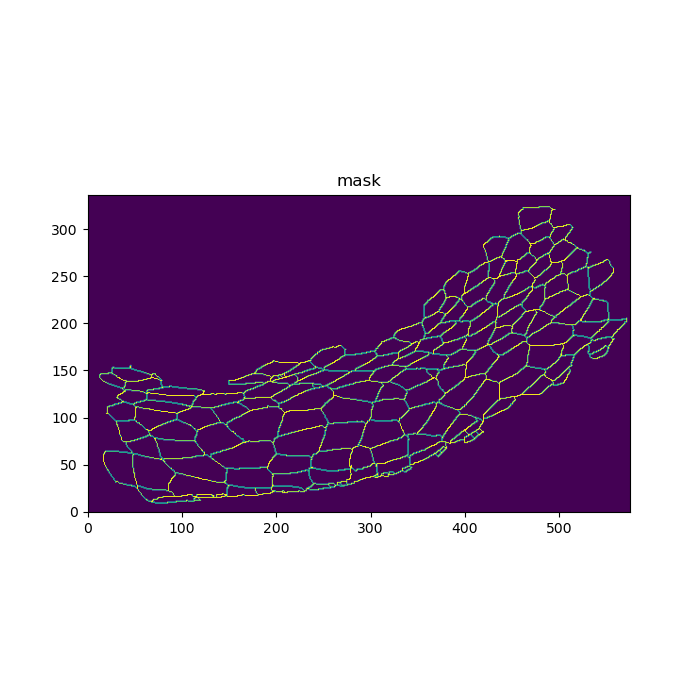

In [36]:
# Generate mask

skel.specs = specs
mask = skel.create_binary_image()

plt.figure(figsize=(7,7))
plt.imshow(mask, origin='lower')
plt.title('mask')
mask = mask.astype(int)

In [37]:
# Functions to generate kernels of curve intersection 

def generate_nonadjacent_combination(input_list,take_n):
    """ 
    It generates combinations of m taken n at a time where there is no adjacent n.
    INPUT:
        input_list = (iterable) List of elements you want to extract the combination 
        take_n =     (integer) Number of elements that you are going to take at a time in
                     each combination
    OUTPUT:
        all_comb =   (np.array) with all the combinations
    """
    all_comb = []
    for comb in itertools.combinations(input_list, take_n):
        comb = np.array(comb)
        d = np.diff(comb)
        fd = np.diff(np.flip(comb))
        if len(d[d==1]) == 0 and comb[-1] - comb[0] != 7:
            all_comb.append(comb)        
#             print(comb)
    return all_comb


def populate_intersection_kernel(combinations):
    """
    Maps the numbers from 0-7 into the 8 pixels surrounding the center pixel in
    a 9 x 9 matrix clockwisely i.e. up_pixel = 0, right_pixel = 2, etc. And 
    generates a kernel that represents a line intersection, where the center 
    pixel is occupied and 3 or 4 pixels of the border are ocuppied too.
    INPUT:
        combinations = (np.array) matrix where every row is a vector of combinations
    OUTPUT:
        kernels =      (List) list of 9 x 9 kernels/masks. each element is a mask.
    """
    n = len(combinations[0])
    template = np.array((
            [-1, -1, -1],
            [-1, 1, -1],
            [-1, -1, -1]), dtype="int")
    match = [(0,1),(0,2),(1,2),(2,2),(2,1),(2,0),(1,0),(0,0)]
    kernels = []
    for n in combinations:
        tmp = np.copy(template)
        for m in n:
            tmp[match[m][0],match[m][1]] = 1
        kernels.append(tmp)
    return kernels


def give_intersection_kernels():
    """
    Generates all the intersection kernels in a 9x9 matrix.
    INPUT:
        None
    OUTPUT:
        kernels =      (List) list of 9 x 9 kernels/masks. each element is a mask.
    """
    input_list = np.arange(8)
    taken_n = [4,3]
    kernels = []
    for taken in taken_n:
        comb = generate_nonadjacent_combination(input_list,taken)
        tmp_ker = populate_intersection_kernel(comb)
        kernels.extend(tmp_ker)
    return kernels

from scipy import ndimage
# Find the curve intersections
def find_line_intersection(input_image, show=0):
    """
    Applies morphologyEx with parameter HitsMiss to look for all the curve 
    intersection kernels generated with give_intersection_kernels() function.
    INPUT:
        input_image =  (np.array dtype=np.uint8) binarized m x n image matrix
    OUTPUT:
        output_image = (np.array dtype=np.uint8) image where the nonzero pixels 
                       are the line intersection.
    """
    kernel = np.array(give_intersection_kernels())
    output_image = np.zeros(input_image.shape)
    for i in np.arange(len(kernel)):
        out = ndimage.binary_hit_or_miss(mask, np.where(kernel[i]==-1, 0, kernel[i]) )
        output_image = output_image + out
    if show == 1:
        show_image = np.reshape(np.repeat(input_image, 3, axis=1),(input_image.shape[0],input_image.shape[1],3))*255
        show_image[:,:,1] = show_image[:,:,1] -  output_image *255
        show_image[:,:,2] = show_image[:,:,2] -  output_image *255
        plt.imshow(show_image)
    return output_image

#  finding corners
def find_endoflines(input_image, show=0):
    """
    """
    kernel_0 = np.array((
            [-1, -1, -1],
            [-1, 1, -1],
            [-1, 1, -1]), dtype="int")

    kernel_1 = np.array((
            [-1, -1, -1],
            [-1, 1, -1],
            [1,-1, -1]), dtype="int")

    kernel_2 = np.array((
            [-1, -1, -1],
            [1, 1, -1],
            [-1,-1, -1]), dtype="int")

    kernel_3 = np.array((
            [1, -1, -1],
            [-1, 1, -1],
            [-1,-1, -1]), dtype="int")

    kernel_4 = np.array((
            [-1, 1, -1],
            [-1, 1, -1],
            [-1,-1, -1]), dtype="int")

    kernel_5 = np.array((
            [-1, -1, 1],
            [-1, 1, -1],
            [-1,-1, -1]), dtype="int")

    kernel_6 = np.array((
            [-1, -1, -1],
            [-1, 1, 1],
            [-1,-1, -1]), dtype="int")

    kernel_7 = np.array((
            [-1, -1, -1],
            [-1, 1, -1],
            [-1,-1, 1]), dtype="int")

    kernel = np.array((kernel_0,kernel_1,kernel_2,kernel_3,kernel_4,kernel_5,kernel_6, kernel_7))
    output_image = np.zeros(input_image.shape)
    for i in np.arange(8):
        out = cv2.morphologyEx(input_image, cv2.MORPH_HITMISS, kernel[i,:,:])
        output_image = output_image + out

    if show == 1:
        show_image = np.reshape(np.repeat(input_image, 3, axis=1),(input_image.shape[0],input_image.shape[1],3))*255
        show_image[:,:,1] = show_image[:,:,1] -  output_image *255
        show_image[:,:,2] = show_image[:,:,2] -  output_image *255
        plt.imshow(show_image)    

    return output_image#, np.where(output_image == 1)



In [81]:
import cv2
import itertools
from skimage import morphology
# 0- Find end of lines
mask = morphology.skeletonize(mask)
input_image = mask.astype(np.uint8) # must be blaack and white thin network image
eol_img = find_endoflines(input_image, 0)

# 1- Find curve Intersections
lint_img = find_line_intersection(input_image, 0)

# 2- Put together all the nodes
nodes = eol_img + lint_img


In [100]:
from scipy import ndimage
test_3d = np.array([[[0,0,0,0],
                   [0,1,0,0],
                   [0,0,0,0]],
                  [[0,1,0,0],
                   [1,1,1,0],
                   [0,1,0,0]],
                  [[0,0,0,0],
                   [0,1,0,0],
                   [0,0,0,0]]])

pattern = np.array([[[0,0,0],
                   [0,1,0],
                   [0,0,0]],
                  [[0,1,0],
                   [1,1,1],
                   [0,1,0]],
                  [[0,0,0],
                   [0,1,0],
                   [0,0,0]]])
output_image = np.zeros(test_3d.shape)
for i in np.arange(len(kernel)):
    out = ndimage.binary_hit_or_miss(test_3d, pattern)
    output_image += out

In [103]:
output_image

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0., 18.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

<IPython.core.display.Javascript object>


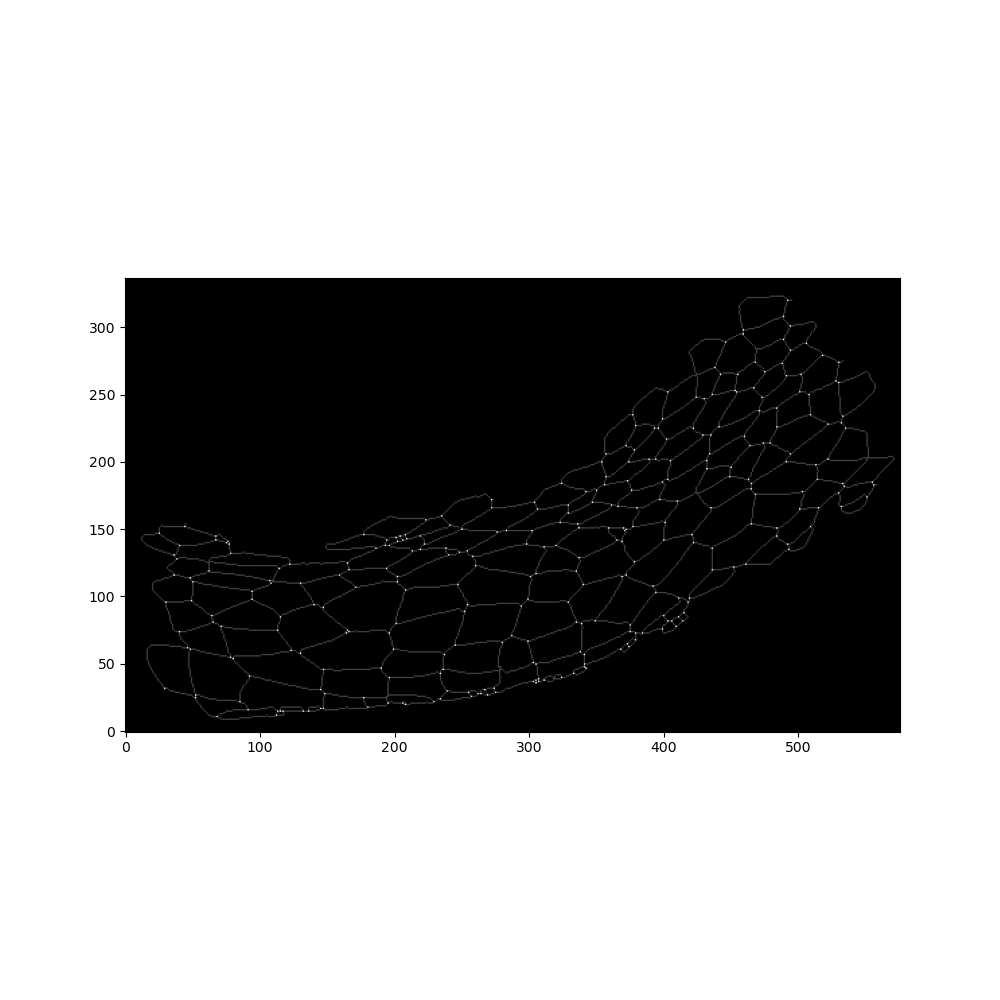

In [98]:
plt.figure(figsize=(10,10))
# plt.imshow(mask, origin='lower')
plt.imshow(5*mask+15*output_image, origin='lower', cmap='gist_gray')

<IPython.core.display.Javascript object>


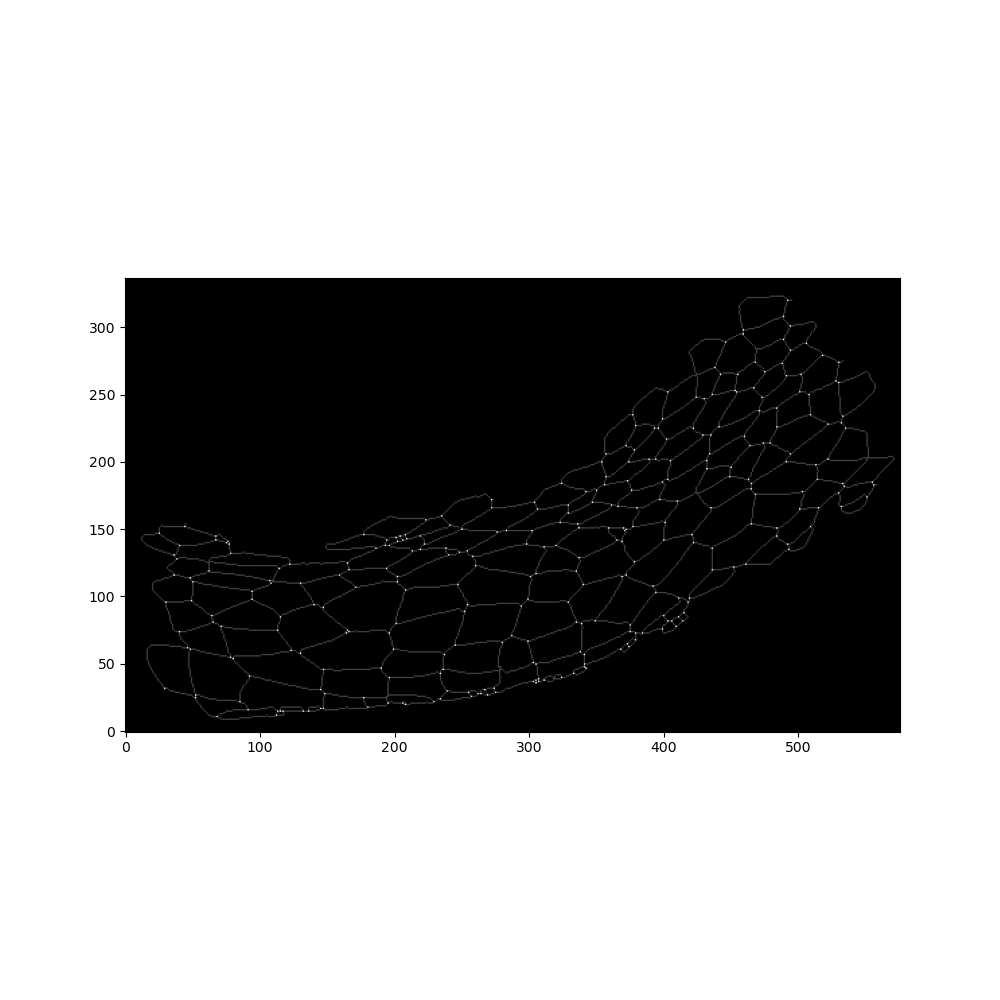

In [83]:
plt.figure(figsize=(10,10))
# plt.imshow(mask, origin='lower')
plt.imshow(5*mask+15*lint_img, origin='lower', cmap='gist_gray')

<IPython.core.display.Javascript object>


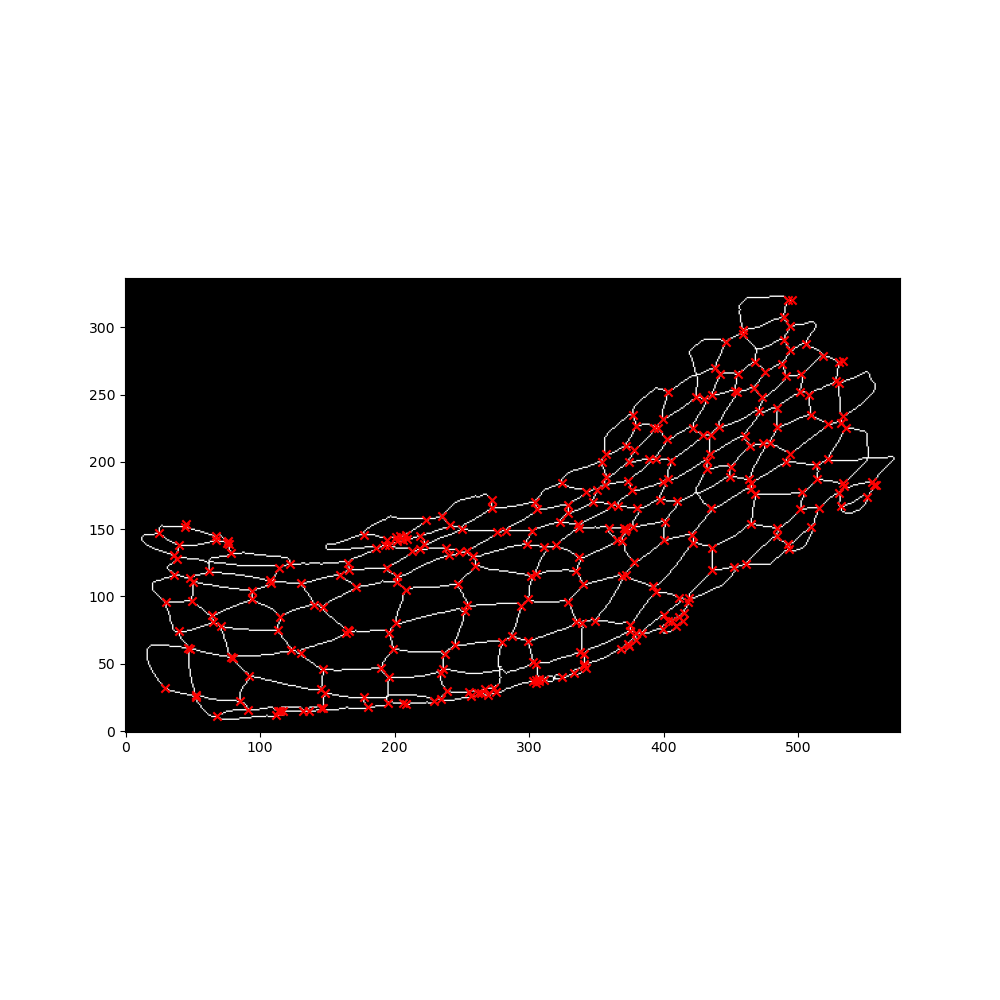

In [84]:
# import numpy as np
import pylab as pl
from matplotlib import collections  as mc
x,y = np.where(nodes==1)
fig, ax = pl.subplots(figsize=(10,10))
ax.set_aspect('equal')


plt.imshow(mask, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(y, x, color='r', marker='x')


In [ ]:
# Elargissement
mask_dilation = dilation(mask, 1)
plt.figure(figsize=(7,7))
plt.imshow(mask_dilation, origin='lower')
plt.title('mask_dilation')




In [ ]:
# Supperposition image originale + masque elargi
fig, ax = plt.subplots()
ax.imshow(image, origin='lower')
y,x = np.where(mask_dilation != 0)
ax.scatter(x,y, alpha=0.2, s=2, color='white')
plt.title('Masque Dilation + image original')

In [ ]:
# Background
plt.figure()
plt.imshow((1-mask_dilation) * image, origin='lower')
plt.title('background signal')


#Junction
plt.figure()
plt.imshow(mask_dilation*image, origin='lower')
plt.title('Junctional signal')


In [ ]:
#from Dissects.analysis import general_analysis
print('mean background =',general_analysis(image, mask_dilation)[0], ',',
      'std =', general_analysis(image, mask_dilation)[1])

print('mean junctional signal=',general_analysis(image, mask_dilation)[2], ',',
      'std =', general_analysis(image, mask_dilation)[3])


# Vertices méthode Tatiana 



In [ ]:
seg = segmentation(mask)

face_df, edge_df, vert_df = generate_mesh(mask, seg, 1, )


In [ ]:

plt.figure(figsize=(10,10))
plt.imshow(image, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(vert_df['y'], vert_df['x'], color='b')
plt.scatter(face_df['y'], face_df['x'], color='r', marker='+')

In [ ]:
# import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for _, e  in edge_df.iterrows():
    lines.append(([(vert_df['y'][e.v1], vert_df['x'][e.v1]),
                   (vert_df['y'][e.v2], vert_df['x'][e.v2])
                  ]))



cc = vert_df.loc[edge_df['v1']]['x']
lc = mc.LineCollection(lines, cc, cmap='plasma_r', linewidth=2, alpha=1)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
ax.set_aspect('equal')


plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(vert_df['y'], vert_df['x'], color='r', marker='x')
# plt.scatter(face_df['y'], face_df['x'], color='b', marker='+')

In [ ]:
image_vertex, list_vertices, df_vertices = vertices(mask, seg, 1)

# Edge detection
df4_jonctions = junctions(list_vertices, df_vertices)

In [ ]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for i in range (0, df4_jonctions.shape[0]) :
    lines.append(([(df4_jonctions['y0'][i],df4_jonctions['x0'][i]),
                   (df4_jonctions['y1'][i],df4_jonctions['x1'][i])]))



cc = df4_jonctions['x0']
lc = mc.LineCollection(lines, cc, cmap='plasma_r', linewidth=2, alpha=1)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
#ax.scatter(x,y,color='r', zorder=10, s = 7)
ax.set_aspect('equal')

#plt.imshow(image, origin='lower')

plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df4_jonctions['y1'], df4_jonctions['x1'], color='b')
plt.scatter(df_vertices['y_0'], df_vertices['x_0'], color='r', marker='x')